# Procesamiento y limpieza

traducción de textos en lenguas cooficiales españolas

In [1]:
!pip install googletrans

In [49]:
!pip install pandas nltk TextBlob transformers torch spacy

In [30]:
import csv
from googletrans import Translator

input_file = 'EURES_LIMPIO.csv'
output_file = 'EURES_TRADUCIDO.csv'
provincias_catalanas = {'Barcelona', 'Girona', 'Tarragona', 'Lleida'}
translator = Translator()

with open(input_file, 'r', encoding='utf-8') as fin, open(output_file, 'w', encoding='utf-8', newline='') as fout:
    reader = csv.DictReader(fin, delimiter=';')
    fieldnames = reader.fieldnames
    writer = csv.DictWriter(fout, fieldnames=fieldnames, delimiter=';')
    writer.writeheader()
    for row in reader:
        region = row.get('region', '')
        if region in provincias_catalanas:
            desc = row.get('descripcion', '')
            # Detectar si hay catalán (heurística simple: palabras típicas)
            if any(pal in desc.lower() for pal in ['amb', 'per', 'dilluns', 'divendres', 'dimecres', 'dijous', 'dissabte', 'diumenge', 'treballar', 'ofereix', 'incorporació', 'contracte', 'empresa', 'persones', 'serveis', 'activitat', 'atenció', 'domiciliària', 'grans', 'català', 'castellà', 'client', 'oferta', 'inscripció', 'referència', 'convocatòria', 'col·lectiu', 'conveni', 'salarial', 'torn', 'matí', 'tarda', 'horari', 'dilluns', 'divendres', 'dimecres', 'dijous', 'dissabte', 'diumenge']):
                try:
                    translated = translator.translate(desc, src='ca', dest='es').text
                    row['descripcion'] = translated
                except Exception:
                    pass  # Si falla la traducción, deja el texto original
        writer.writerow(row)
print('Traducción completada')


Traducción completada


In [32]:
df = pd.read_csv("EURES_TRADUCIDO.csv",sep=";")
df.head()

,id,timestamp,titulo,ocupacion,descripcion,provincia,tipo_contrato,descripcion_proc
0,https://europa.eu/eures/portal/jv-se/jv-detail...,10/10/2025,AGENTE COMERCIAL DE SEGUROS (REF.: 6891),corredor de seguros/corredora de seguros,tareas:prospección de nuevos asegurados.planif...,Asturias,Contrato,tarea prospección asegurado planificación gest...
1,https://europa.eu/eures/portal/jv-se/jv-detail...,10/10/2025,PERSONAL CONDUCCIÓN DE CAMIONES RÍGIDOS Y GÓND...,Conductor de vehículo de carga/conductora de v...,descripción: se necesita cubrir cuatro puestos...,Huesca,Contrato,descripción necesitar cubrir puesto empresa mo...
2,https://europa.eu/eures/portal/jv-se/jv-detail...,10/10/2025,EDUCADORES SOCIALES,Trabajador social/trabajadora social,educador social para hogar en arinaga. fines d...,Las Palmas,Determinado,educador social hogar arinaga fin semana festi...
3,https://europa.eu/eures/portal/jv-se/jv-detail...,10/10/2025,PIZZERO (REF. 042025002051),Pizzero/pizzera,funciones: elaboración de pizzas requisitos: 2...,Islas Baleares,Determinado,función elaboración pizza requisito mes experi...
4,https://europa.eu/eures/portal/jv-se/jv-detail...,10/10/2025,INTÉRPRETES DE LA LENGUA DE SIGNOS,intérprete de lengua de signos,intérprete de lengua de signos para puestos en...,Santa Cruz de Tenerife,Determinado,intérprete lengua signo puesto ies manuel mart...


limpieza de generos dobles y preprocesado de texto (minusculas, eliminar puntuacion y números, espacios dobles y tokenizacion + lematizacion con spacy)


In [34]:
import re
import pandas as pd
import spacy
import spacy.cli

# Download the Spanish language model
spacy.cli.download("es_core_news_sm")

nlp = spacy.load("es_core_news_sm", disable=["ner", "parser"])

# REGEX para eliminar solo marcas /a, /as, /o, /os sin tocar /año o /agosto
RE_GENERO = re.compile(r'(\b\w+)\s*/[ao]s?(?!\w)', flags=re.UNICODE)

# Clase de puntuación SIN la barra (la borramos más adelante)
PUNCT_SIN_SLASH = r"[.,;:()\[\]{}¿?!¡\"'_\-«»…%]"

def quitar_marcas_genero(texto: str) -> str:
    """Elimina /a, /as, /o, /os solo si son marcas de género."""
    return RE_GENERO.sub(r'\1', texto)

def limpiar_texto(texto):
    """Limpieza completa previa a la lematización."""
    if pd.isna(texto):
        return ""
    t = str(texto).lower()  # a minúsculas
    t = quitar_marcas_genero(t)  # quitar /a, /as, /o, /os
    t = re.sub(r"\d+", " ", t)  # quitar números
    t = re.sub(PUNCT_SIN_SLASH, " ", t)  # quitar puntuación (sin la barra)
    t = re.sub(r"/", " ", t)  # quitar barras restantes
    t = re.sub(r"\s+", " ", t).strip()  # quitar espacios múltiples
    return t

def procesar(texto):
    """Lematiza y elimina stopwords con spaCy."""
    t = limpiar_texto(texto)
    doc = nlp(t)
    tokens = [tok.lemma_ for tok in doc if not tok.is_stop and tok.lemma_]
    return " ".join(tokens)


# aplicar
df["descripcion_proc"] = df["descripcion"].apply(procesar)

# guardar el preproceso
df.to_csv("EURES_PROCESADO.csv", sep=";", index=False, encoding="utf-8-sig")

✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


# Volumen temporal de publicaciones

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_temporalidad(datos, titulo):
    fig, ax = plt.subplots(figsize=(12, 5))

    # Detectar frecuencia esperada
    modo = titulo.lower()
    fechas = pd.to_datetime(datos.index)

    if modo == "diario":
        rango = pd.date_range(fechas.min(), fechas.max(), freq='D')
    elif modo == "semanal":
        rango = pd.date_range(fechas.min(), fechas.max(), freq='W-MON')
    elif modo == "mensual":
        rango = pd.date_range(fechas.min(), fechas.max(), freq='MS')
    else:
        rango = fechas  # sin reindexado si no se reconoce el modo

    # Reindexar para incluir fechas faltantes con valor 0
    datos = datos.reindex(rango, fill_value=0)

    # Graficar con colores si es diario
    if modo == "diario":
        colores = ['tomato' if fecha.weekday() >= 5 else 'steelblue' for fecha in datos.index]
        ax.bar(datos.index, datos.values, color=colores)
    else:
        datos.plot(kind='bar', ax=ax, color='steelblue')

    ax.set_title(f'Volumen {titulo} de publicaciones')
    ax.set_xlabel('Fecha')
    ax.set_ylabel('Número de publicaciones')
    plt.tight_layout()
    plt.show()


In [6]:
df = pd.read_csv("../empleos-espanoles-eures-2025.csv", sep=";")  #cambiar la ruta
df['timestamp'] = pd.to_datetime(df["timestamp"], format="%d/%m/%Y")
df.head()

,id,timestamp,titulo,ocupacion,descripcion,provincia,tipo_contrato
0,https://europa.eu/eures/portal/jv-se/jv-detail...,2025-10-10,AGENTE COMERCIAL DE SEGUROS (REF.: 6891),corredor de seguros/corredora de seguros,TAREAS:Prospección de nuevos asegurados/as.Pla...,Asturias,Contrato
1,https://europa.eu/eures/portal/jv-se/jv-detail...,2025-10-10,PERSONAL CONDUCCIÓN DE CAMIONES RÍGIDOS Y GÓND...,Conductor de vehículo de carga/conductora de v...,DESCRIPCIÓN: Se necesita cubrir cuatro puestos...,Huesca,Contrato
2,https://europa.eu/eures/portal/jv-se/jv-detail...,2025-10-10,EDUCADORES SOCIALES,Trabajador social/trabajadora social,EDUCADOR/A SOCIAL PARA HOGAR EN ARINAGA. FINES...,Las Palmas,Determinado
3,https://europa.eu/eures/portal/jv-se/jv-detail...,2025-10-10,PIZZERO/A (REF. 042025002051),Pizzero/pizzera,FUNCIONES: Elaboración de pizzas REQUISITOS: 2...,Islas Baleares,Determinado
4,https://europa.eu/eures/portal/jv-se/jv-detail...,2025-10-10,INTÉRPRETES DE LA LENGUA DE SIGNOS,intérprete de lengua de signos,INTÉRPRETE DE LENGUA DE SIGNOS PARA PUESTOS EN...,Santa Cruz de Tenerife,Determinado


In [7]:
df = df[df['timestamp'] <= pd.Timestamp("2026-02-01")]

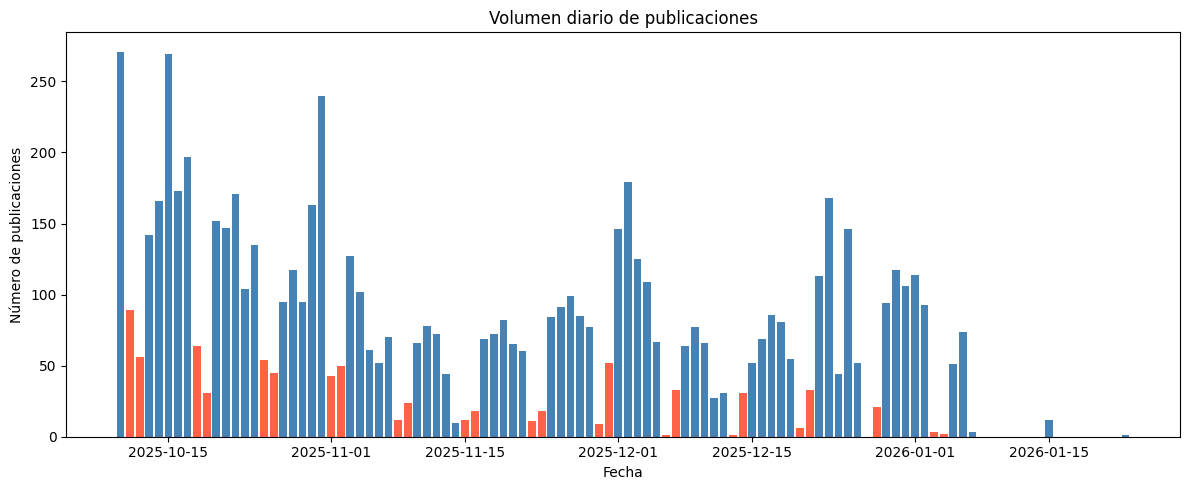

In [8]:
conteo_dia = df.groupby(df['timestamp'].dt.date).size()
plot_temporalidad(conteo_dia, "diario")

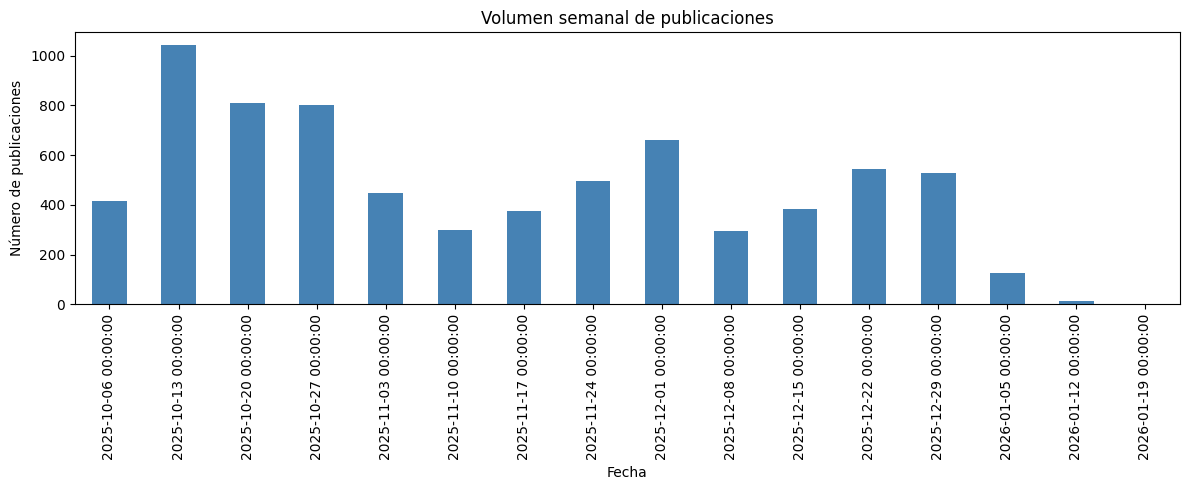

In [9]:
conteo_semana = df.groupby(df['timestamp'].dt.to_period('W')).size()
conteo_semana.index = conteo_semana.index.to_timestamp()
plot_temporalidad(conteo_semana, "semanal")

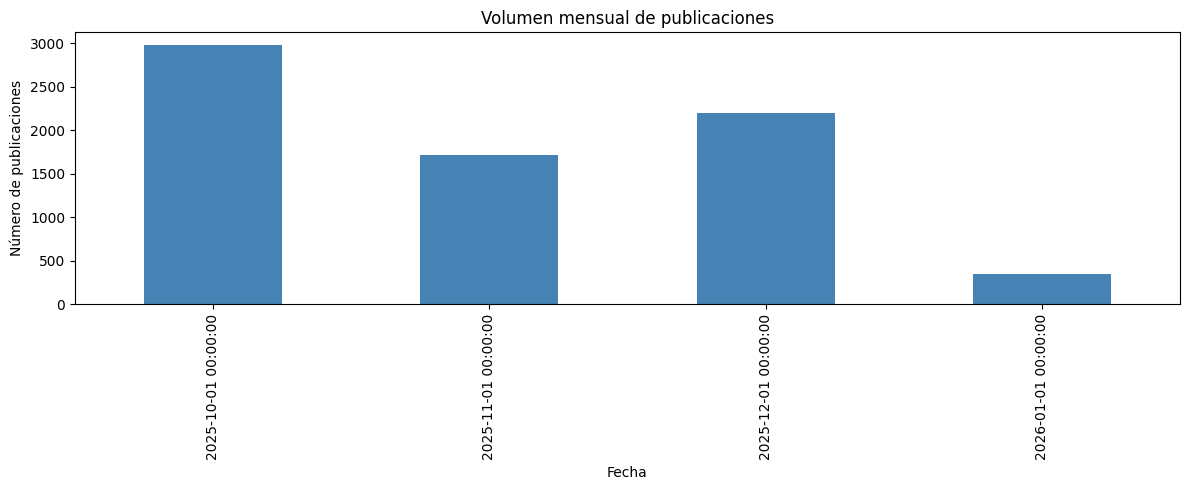

In [10]:
conteo_mes = df.groupby(df['timestamp'].dt.to_period('M')).size()
conteo_mes.index = conteo_mes.index.to_timestamp()
plot_temporalidad(conteo_mes, "mensual")

In [11]:
df.tipo_contrato.value_counts()

,count
tipo_contrato,
Contrato,4625
Determinado,2384
Temporal,173
Autónomo,51
Self-employed,4
Puesto de aprendiz,3
Apprenticeship,1
Empleo con posibilidad de contratación,1


# Indicadores opcionales Clasificación temática asistida por LLM

In [36]:
df = pd.read_csv("EURES_PROCESADO.csv", sep=";")
df.head()


,id,timestamp,titulo,ocupacion,descripcion,provincia,tipo_contrato,descripcion_proc
0,https://europa.eu/eures/portal/jv-se/jv-detail...,10/10/2025,AGENTE COMERCIAL DE SEGUROS (REF.: 6891),corredor de seguros/corredora de seguros,tareas:prospección de nuevos asegurados.planif...,Asturias,Contrato,tarea prospección asegurado planificación gest...
1,https://europa.eu/eures/portal/jv-se/jv-detail...,10/10/2025,PERSONAL CONDUCCIÓN DE CAMIONES RÍGIDOS Y GÓND...,Conductor de vehículo de carga/conductora de v...,descripción: se necesita cubrir cuatro puestos...,Huesca,Contrato,descripción necesitar cubrir puesto empresa mo...
2,https://europa.eu/eures/portal/jv-se/jv-detail...,10/10/2025,EDUCADORES SOCIALES,Trabajador social/trabajadora social,educador social para hogar en arinaga. fines d...,Las Palmas,Determinado,educador social hogar arinaga fin semana festi...
3,https://europa.eu/eures/portal/jv-se/jv-detail...,10/10/2025,PIZZERO (REF. 042025002051),Pizzero/pizzera,funciones: elaboración de pizzas requisitos: 2...,Islas Baleares,Determinado,función elaboración pizza requisito mes experi...
4,https://europa.eu/eures/portal/jv-se/jv-detail...,10/10/2025,INTÉRPRETES DE LA LENGUA DE SIGNOS,intérprete de lengua de signos,intérprete de lengua de signos para puestos en...,Santa Cruz de Tenerife,Determinado,intérprete lengua signo puesto ies manuel mart...


## Zero-shot

In [12]:
!pip install transformers[sentencepiece]
!pip install 'accelerate>=0.26.0'

In [37]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import torch, string


### 1. Definir etiquetas


In [38]:
etiquetas = [
    "Hostelería y Turismo",
    "Sanitario y Salud",
    "Educación y Formación",
    "Tecnología y Telecomunicaciones",
    "Construcción e Inmobiliaria",
    "Industria y Manufactura",
    "Comercio y Ventas",
    "Logística y Transporte",
    "Administración y Finanzas",
    "Cultura, Arte y Ocio"
]

### 3. Inicializar modelos

In [39]:
clf1 = pipeline(
    "zero-shot-classification",
    model="MoritzLaurer/deberta-v3-large-zeroshot-v2.0",
    device=0
)

clf2 = pipeline(
    "zero-shot-classification",
    model="Recognai/zeroshot_selectra_medium",
    device=0
)

tokenizer3 = AutoTokenizer.from_pretrained("DAMO-NLP-SG/zero-shot-classify-SSTuning-XLM-R")
model3 = AutoModelForSequenceClassification.from_pretrained(
    "DAMO-NLP-SG/zero-shot-classify-SSTuning-XLM-R")
list_ABC = [x for x in string.ascii_uppercase]

def classify_model3(text, labels):
    labels = [x+'.' if not x.endswith('.') else x for x in labels]
    labels_new = labels + [tokenizer3.pad_token] * (20 - len(labels))
    s_option = ' '.join([f'({list_ABC[i]}) {labels_new[i]}' for i in range(len(labels_new))])
    text_input = f'{s_option} {tokenizer3.sep_token} {text}'
    encoding = tokenizer3([text_input], truncation=True, max_length=512, return_tensors='pt')
    # No movemos a device manualmente, lo gestiona accelerate
    logits = model3(**encoding).logits
    logits = logits[:, :len(labels)]
    probs = torch.nn.functional.softmax(logits, dim=-1).tolist()[0]
    return list(zip([lab.strip('.') for lab in labels], probs))

Device set to use cuda:0
Device set to use cuda:0


### 4. Voting classifier


In [40]:
def classify_offer(text):
    # Modelo 1
    out1 = clf1(text, etiquetas, hypothesis_template="Este texto es sobre {}")
    probs1 = {lab: score for lab, score in zip(out1["labels"], out1["scores"])}

    # Modelo 2
    out2 = clf2(text, candidate_labels=etiquetas, hypothesis_template="Este ejemplo es {}.")
    probs2 = {lab: score for lab, score in zip(out2["labels"], out2["scores"])}

    # Modelo 3
    results3 = classify_model3(text, etiquetas)  # <-- modificado para devolver lista (label, prob)
    probs3 = {lab.strip('.'): prob for lab, prob in results3}

    # Combinar: promedio de probabilidades
    combined = {}
    for lab in etiquetas:
        combined[lab] = np.mean([
            probs1.get(lab, 0),
            probs2.get(lab, 0),
            probs3.get(lab, 0)
        ])

    # Seleccionar la clase con mayor probabilidad media
    final = max(combined, key=combined.get)
    return final, combined



### 5. Aplicar al dataset


In [41]:
BATCH_SIZE = 8  # ajusta según tu GPU

def classify_batch(texts):
    results = []
    # Modelo 1
    out1 = clf1(texts, etiquetas, hypothesis_template="Este texto es sobre {}")
    # Modelo 2
    out2 = clf2(texts, candidate_labels=etiquetas, hypothesis_template="Este ejemplo es {}.")
    # Modelo 3 (aún fila a fila, pero podrías vectorizarlo)
    out3 = [classify_model3(t, etiquetas) for t in texts]

    for i, text in enumerate(texts):
        probs1 = {lab: score for lab, score in zip(out1[i]["labels"], out1[i]["scores"])}
        probs2 = {lab: score for lab, score in zip(out2[i]["labels"], out2[i]["scores"])}
        probs3 = {lab: prob for lab, prob in out3[i]}

        combined = {lab: np.mean([
            probs1.get(lab, 0),
            probs2.get(lab, 0),
            probs3.get(lab, 0)
        ]) for lab in etiquetas}

        final = max(combined, key=combined.get)
        results.append((final, combined))
    return results

# Aplicar en lotes con barra de progreso
sectors, probs = [], []
for i in tqdm(range(0, len(df), BATCH_SIZE)):
    batch = df["ocupacion"].iloc[i:i+BATCH_SIZE].tolist()
    batch_results = classify_batch(batch)
    for f, c in batch_results:
        sectors.append(f)
        probs.append(c)

df["sector"] = sectors
df["probs"] = probs


100%|██████████| 908/908 [1:53:20<00:00,  7.49s/it]


In [44]:
# Guardar resultados
df.to_csv("EURES_CATEGORIZADO.csv", sep=";", index=False)
df.head()

,id,timestamp,titulo,ocupacion,descripcion,provincia,tipo_contrato,descripcion_proc,sector,probs
0,https://europa.eu/eures/portal/jv-se/jv-detail...,10/10/2025,AGENTE COMERCIAL DE SEGUROS (REF.: 6891),corredor de seguros/corredora de seguros,tareas:prospección de nuevos asegurados.planif...,Asturias,Contrato,tarea prospección asegurado planificación gest...,Administración y Finanzas,"{'Hostelería y Turismo': 0.04140392038971186, ..."
1,https://europa.eu/eures/portal/jv-se/jv-detail...,10/10/2025,PERSONAL CONDUCCIÓN DE CAMIONES RÍGIDOS Y GÓND...,Conductor de vehículo de carga/conductora de v...,descripción: se necesita cubrir cuatro puestos...,Huesca,Contrato,descripción necesitar cubrir puesto empresa mo...,Logística y Transporte,"{'Hostelería y Turismo': 0.030990238456676405,..."
2,https://europa.eu/eures/portal/jv-se/jv-detail...,10/10/2025,EDUCADORES SOCIALES,Trabajador social/trabajadora social,educador social para hogar en arinaga. fines d...,Las Palmas,Determinado,educador social hogar arinaga fin semana festi...,Educación y Formación,"{'Hostelería y Turismo': 0.09140267844001453, ..."
3,https://europa.eu/eures/portal/jv-se/jv-detail...,10/10/2025,PIZZERO (REF. 042025002051),Pizzero/pizzera,funciones: elaboración de pizzas requisitos: 2...,Islas Baleares,Determinado,función elaboración pizza requisito mes experi...,Hostelería y Turismo,"{'Hostelería y Turismo': 0.3220151712497075, '..."
4,https://europa.eu/eures/portal/jv-se/jv-detail...,10/10/2025,INTÉRPRETES DE LA LENGUA DE SIGNOS,intérprete de lengua de signos,intérprete de lengua de signos para puestos en...,Santa Cruz de Tenerife,Determinado,intérprete lengua signo puesto ies manuel mart...,"Cultura, Arte y Ocio","{'Hostelería y Turismo': 0.08065285657842954, ..."


In [45]:
df.sector.value_counts()

,count
sector,
Logística y Transporte,1291
Sanitario y Salud,1211
Industria y Manufactura,963
Administración y Finanzas,885
Construcción e Inmobiliaria,791
Hostelería y Turismo,585
Comercio y Ventas,542
Educación y Formación,436
Tecnología y Telecomunicaciones,283


# Análisis de sentimiento

En esta sección aplicamos **análisis de sentimiento** sobre la columna `descripcion` de nuestro dataset, utilizando **tres enfoques complementarios**.  
Posteriormente combinamos sus resultados mediante un **ensamble ponderado (voting classifier)** para obtener una valoración final más robusta.

### Modelos utilizados

1. **VADER (NLTK)**  
   - Modelo basado en reglas y un léxico predefinido de palabras positivas y negativas.  
   - Es muy rápido y eficiente, ideal para texto corto o evaluaciones rápidas.  
   - Devuelve probabilidades de *positivo*, *neutral* y *negativo*.

2. **TextBlob**  
   - Basado en técnicas lingüísticas simples que analizan la polaridad de las palabras.  
   - Genera un valor continuo de sentimiento entre -1 (negativo) y 1 (positivo).  
   - Lo transformamos a una distribución de tres clases para hacerla comparable con los otros modelos.

3. **BETO (BERT entrenado para español)**  
   - Modelo profundo de lenguaje basado en *Transformers*, preentrenado sobre grandes corpus en español.  
   - Permite captar matices semánticos más complejos que los modelos léxicos.  
   - Por limitación del modelo, truncamos los textos a un máximo de **512 tokens** para evitar errores de tamaño.

### Ensemble ponderado

Cada modelo aporta una estimación de sentimiento (`neg`, `neu`, `pos`) y combinamos los resultados mediante una media ponderada.

De este modo damos mayor importancia a BETO, al ser el modelo más contextual y potente.

El resultado final es una etiqueta de sentimiento:
- `-1` → Negativo  
- `0` → Neutral  
- `1` → Positivo  

El resultado se almacena en la nueva columna **`sentimiento`** del DataFrame.


In [51]:
import pandas as pd
import torch
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from transformers import pipeline

nltk.download('vader_lexicon') # descargar el modelo para usar el sentiment analysis

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [52]:
# VADER
sia = SentimentIntensityAnalyzer()

def vader_scores(text: str):
    s = sia.polarity_scores(text)
    return {"neg": float(s["neg"]), "neu": float(s["neu"]), "pos": float(s["pos"])}

# TEXTBLOB
def textblob_scores(text: str):
    p = TextBlob(text).sentiment.polarity
    if p > 0:
        return {"neg": 0.0, "neu": 1 - p, "pos": p}
    elif p < 0:
        return {"neg": abs(p), "neu": 1 - abs(p), "pos": 0.0}
    else:
        return {"neg": 0.05, "neu": 0.9, "pos": 0.05}

# BETO (BERT español)
device = 0 if torch.cuda.is_available() else -1
bert_pipeline = pipeline(
    "sentiment-analysis",
    model="finiteautomata/beto-sentiment-analysis",
    top_k=None,
    device=device
)

def bert_scores(text: str):
    # Truncar texto a 512 tokens
    tokenizer = bert_pipeline.tokenizer
    max_seq_length = 512
    tokens = tokenizer.encode(text, truncation=True, max_length=max_seq_length, return_tensors="pt")
    decoded_text = tokenizer.decode(tokens[0], skip_special_tokens=True)

    # Ejecutar el pipeline
    result = bert_pipeline(decoded_text, top_k=None)

    # Normalizar formato de salida
    if isinstance(result[0], list):
        result = result[0]
    scores = {r["label"].lower(): float(r["score"]) for r in result}
    return {
        "neg": scores.get("neg", 0.0),
        "neu": scores.get("neu", 0.0),
        "pos": scores.get("pos", 0.0)
    }

# ENSEMBLE PONDERADO
def weighted_sentiment(text: str, weights=(0.3, 0.3, 0.4)):
    vader_w, blob_w, bert_w = weights

    v = vader_scores(text)
    t = textblob_scores(text)
    b = bert_scores(text)

    combined = {
        "neg": vader_w * v["neg"] + blob_w * t["neg"] + bert_w * b["neg"],
        "neu": vader_w * v["neu"] + blob_w * t["neu"] + bert_w * b["neu"],
        "pos": vader_w * v["pos"] + blob_w * t["pos"] + bert_w * b["pos"]
    }

    final_label = max(combined, key=combined.get)
    label_map = {"neg": -1, "neu": 0, "pos": 1}
    return label_map[final_label]

config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/528 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0


In [53]:
df = pd.read_csv("EURES_CATEGORIZADO.csv", sep=";")
df["sentimiento"] = df["descripcion_proc"].apply(weighted_sentiment)


In [54]:
df.head()

,id,timestamp,titulo,ocupacion,descripcion,provincia,tipo_contrato,descripcion_proc,sector,probs,sentimiento
0,https://europa.eu/eures/portal/jv-se/jv-detail...,10/10/2025,AGENTE COMERCIAL DE SEGUROS (REF.: 6891),corredor de seguros/corredora de seguros,tareas:prospección de nuevos asegurados.planif...,Asturias,Contrato,tarea prospección asegurado planificación gest...,Administración y Finanzas,{'Hostelería y Turismo': np.float64(0.04140392...,0
1,https://europa.eu/eures/portal/jv-se/jv-detail...,10/10/2025,PERSONAL CONDUCCIÓN DE CAMIONES RÍGIDOS Y GÓND...,Conductor de vehículo de carga/conductora de v...,descripción: se necesita cubrir cuatro puestos...,Huesca,Contrato,descripción necesitar cubrir puesto empresa mo...,Logística y Transporte,{'Hostelería y Turismo': np.float64(0.03099023...,0
2,https://europa.eu/eures/portal/jv-se/jv-detail...,10/10/2025,EDUCADORES SOCIALES,Trabajador social/trabajadora social,educador social para hogar en arinaga. fines d...,Las Palmas,Determinado,educador social hogar arinaga fin semana festi...,Educación y Formación,{'Hostelería y Turismo': np.float64(0.09140267...,0
3,https://europa.eu/eures/portal/jv-se/jv-detail...,10/10/2025,PIZZERO (REF. 042025002051),Pizzero/pizzera,funciones: elaboración de pizzas requisitos: 2...,Islas Baleares,Determinado,función elaboración pizza requisito mes experi...,Hostelería y Turismo,{'Hostelería y Turismo': np.float64(0.32201517...,0
4,https://europa.eu/eures/portal/jv-se/jv-detail...,10/10/2025,INTÉRPRETES DE LA LENGUA DE SIGNOS,intérprete de lengua de signos,intérprete de lengua de signos para puestos en...,Santa Cruz de Tenerife,Determinado,intérprete lengua signo puesto ies manuel mart...,"Cultura, Arte y Ocio",{'Hostelería y Turismo': np.float64(0.08065285...,0


In [55]:
df["sentimiento"].value_counts()

,count
sentimiento,
0,7229
1,30
-1,1


como era de esperar tenemos muy pocas columnas categorizadas con un sentimiento que no es nulo, que se podrá deber al funcionamiento de los modelos y qué consideren positivo o no.

In [56]:
df.to_csv("EURES_CAT_SENTIMENT.csv", sep=";", index=False)

# Distribución de tópicos con LDA

In [57]:
!pip install --upgrade -q gspread

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


In [59]:
df = pd.read_csv("EURES_CAT_SENTIMENT.csv", sep=";")

# Mostrar las primeras filas
df.head()

,id,timestamp,titulo,ocupacion,descripcion,provincia,tipo_contrato,descripcion_proc,sector,probs,sentimiento
0,https://europa.eu/eures/portal/jv-se/jv-detail...,10/10/2025,AGENTE COMERCIAL DE SEGUROS (REF.: 6891),corredor de seguros/corredora de seguros,tareas:prospección de nuevos asegurados.planif...,Asturias,Contrato,tarea prospección asegurado planificación gest...,Administración y Finanzas,{'Hostelería y Turismo': np.float64(0.04140392...,0
1,https://europa.eu/eures/portal/jv-se/jv-detail...,10/10/2025,PERSONAL CONDUCCIÓN DE CAMIONES RÍGIDOS Y GÓND...,Conductor de vehículo de carga/conductora de v...,descripción: se necesita cubrir cuatro puestos...,Huesca,Contrato,descripción necesitar cubrir puesto empresa mo...,Logística y Transporte,{'Hostelería y Turismo': np.float64(0.03099023...,0
2,https://europa.eu/eures/portal/jv-se/jv-detail...,10/10/2025,EDUCADORES SOCIALES,Trabajador social/trabajadora social,educador social para hogar en arinaga. fines d...,Las Palmas,Determinado,educador social hogar arinaga fin semana festi...,Educación y Formación,{'Hostelería y Turismo': np.float64(0.09140267...,0
3,https://europa.eu/eures/portal/jv-se/jv-detail...,10/10/2025,PIZZERO (REF. 042025002051),Pizzero/pizzera,funciones: elaboración de pizzas requisitos: 2...,Islas Baleares,Determinado,función elaboración pizza requisito mes experi...,Hostelería y Turismo,{'Hostelería y Turismo': np.float64(0.32201517...,0
4,https://europa.eu/eures/portal/jv-se/jv-detail...,10/10/2025,INTÉRPRETES DE LA LENGUA DE SIGNOS,intérprete de lengua de signos,intérprete de lengua de signos para puestos en...,Santa Cruz de Tenerife,Determinado,intérprete lengua signo puesto ies manuel mart...,"Cultura, Arte y Ocio",{'Hostelería y Turismo': np.float64(0.08065285...,0


In [60]:
# Lista de textos
documents = df['descripcion_proc'].tolist()
print(f"Total documentos: {len(documents)}")


Total documentos: 7260


In [61]:
import nltk; nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

stop_es = set(stopwords.words('spanish'))
stop_en = set(stopwords.words('english'))

extra_stops = {'oferta', 'número', 'experiencia', 'contrato', 'jornada',
               'trabajo', 'email', 'empleo', 'cod', 'horario', 'dni', 'nie',
               'inscrito', 'función', 'salario', 'requisito', 'persona',
               'referencia', 'currículo', 'laboral', 'labora', 'imprescindible',
               'trabajar', 'interesado', 'contacto', 'currículum', 'org', 'www',
               'contacto', 'dato', 'interesado', 'condición' 'amb', 'curriculum',
               'candatura', 'per', 'punt', 'puntlaboro', 'ofrecer', 'gva',
               'lang', 'emp', 'convenio', 'condición', 'indicar', 'asunto',
               'empleocastillayleon', 'comunidad', 'portal', 'app', 'jcyl',
               'teléfono', 'lunes', 'viernes', 'incorporar', 'semanal',
               'postular', 'llamar', 'conocimiento', 'incorporación',
               'especificar', 'residir', 'formación', 'mes', 'año',
               'valorar', 'oficinavirtual', 'necesitar', 'ubicado',
               'disponibilidad', 'adjuntar', 'turno', 'semana', 'pdf', 'etc',
               'similar', 'mejor','quieres',
                 'amb', 'vigente', 'hrs', 'correctamente', 'marca', 'núm','neto'
}

ccaa = {
    'andalucia', 'aragón', 'asturias', 'cantabria', 'mancha',
    'león', 'castilla', 'cataluña', 'catalunya', 'extremadura', 'galicia',
    'madrid', 'murcia', 'navarra', 'rioja', 'vasco', 'euskadi',
    'valencia','valenciana', 'canarias', 'baleares', 'santander', 'teruel', 'san', 'sebastián', 'sabadell','lleida', 'españa'
}
my_stop_words = stop_es.union(stop_en).union(extra_stops).union(ccaa)

# 2) Vectorizador afinado para español (Unicode + tildes/ñ), sin números
tf_vectorizer = CountVectorizer(
    stop_words=list(my_stop_words), # Convert the set to a list
    min_df=4,
    max_df=0.01,
    lowercase=True,
    max_features=60000,
    token_pattern=r'(?u)\b[^\W\d_]{3,}\b',  # solo letras unicode (incluye áéíóúüñ)
    analyzer='word'
)

bag_of_words = tf_vectorizer.fit_transform(documents)
dictionary = tf_vectorizer.get_feature_names_out()
print("Tamaño del vocabulario:", len(dictionary))

# 3) Top términos para revisar y ampliar stopwords si hace falta
import numpy as np
s = np.asarray(bag_of_words.sum(axis=0)).ravel()
st = s.argsort()[::-1]
for i, idx in enumerate(st[:30]):
    print(dictionary[idx], int(s[idx]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Tamaño del vocabulario: 3363
disfrutarás 98
ocupacional 96
ambiental 90
reto 90
economía 87
sexual 85
delito 84
solicitud 83
civil 83
quier 80
manual 80
revisión 78
coordinar 78
albañil 77
interpretación 77
libre 76
alimentario 76
ingeniero 75
autónomo 75
pintura 75
remitir 75
suplencia 75
fiscal 74
acompañamiento 74
lengua 74
carretillero 74
residencial 73
incapacidad 73
requerimiento 73
supervisar 73


In [62]:
topics = 8
alpha = 0.2
beta = 0.3

lda = LatentDirichletAllocation(
    n_components=topics,
    doc_topic_prior=alpha,
    topic_word_prior=beta,
    max_iter=25,
    learning_method='online',
    evaluate_every=1,
    random_state=0,
    n_jobs=-1,
    verbose=1
)

lda.fit(bag_of_words)


iteration: 1 of max_iter: 25, perplexity: 3436.4081
iteration: 2 of max_iter: 25, perplexity: 2911.9229
iteration: 3 of max_iter: 25, perplexity: 2757.3453
iteration: 4 of max_iter: 25, perplexity: 2683.9453
iteration: 5 of max_iter: 25, perplexity: 2640.5243
iteration: 6 of max_iter: 25, perplexity: 2610.3004
iteration: 7 of max_iter: 25, perplexity: 2585.9567
iteration: 8 of max_iter: 25, perplexity: 2567.2612
iteration: 9 of max_iter: 25, perplexity: 2551.4856
iteration: 10 of max_iter: 25, perplexity: 2537.6906
iteration: 11 of max_iter: 25, perplexity: 2526.8539
iteration: 12 of max_iter: 25, perplexity: 2517.5955
iteration: 13 of max_iter: 25, perplexity: 2510.3135
iteration: 14 of max_iter: 25, perplexity: 2504.3916
iteration: 15 of max_iter: 25, perplexity: 2498.7104
iteration: 16 of max_iter: 25, perplexity: 2493.7292
iteration: 17 of max_iter: 25, perplexity: 2489.4656
iteration: 18 of max_iter: 25, perplexity: 2485.5725
iteration: 19 of max_iter: 25, perplexity: 2481.8570
it

LatentDirichletAllocation(doc_topic_prior=0.2, evaluate_every=1,
                          learning_method='online', max_iter=25, n_components=8,
                          n_jobs=-1, random_state=0, topic_word_prior=0.3,
                          verbose=1)

In [63]:
no_top_words = 10
for topic_idx, topic in enumerate(lda.components_):
    print(f"\n Tópico {topic_idx+1}:")
    print(" | ".join([dictionary[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))



 Tópico 1:
ocupacional | solicitud | libre | dinámica | santa | pintura | cultural | supermercado | entusiasta | pasión

 Tópico 2:
disfrutarás | reto | suplencia | división | serie | automoción | industria | sentar | pensado | importar

 Tópico 3:
alimentario | casa | incapacidad | bajo | flexibilidad | telefónico | reconocido | asignado | cuadrante | logística

 Tópico 4:
manual | fiscal | facturación | elevadoro | autónomo | madera | efectivo | despacho | cita | técnica

 Tópico 5:
coordinar | albañil | cet | funcional | presencial | granollers | mercado | marketing | experto | director

 Tópico 6:
carretillero | sala | economía | huesca | letra | citar | químico | decidir | grúa | pintor

 Tópico 7:
lengua | ambiental | dirigido | aprendizaje | quier | firme | adolescente | artículo | ocupar | jardinería

 Tópico 8:
civil | acompañamiento | ingeniero | docencia | junio | climatización | especialidad | mental | extraescolar | vivienda


In [64]:
doc_topics = lda.transform(bag_of_words)
df['topico'] = doc_topics.argmax(axis=1)
df['topico_prob'] = doc_topics.max(axis=1)

df[['id', 'timestamp', 'titulo', 'topico', 'topico_prob']].head()


,id,timestamp,titulo,topico,topico_prob
0,https://europa.eu/eures/portal/jv-se/jv-detail...,10/10/2025,AGENTE COMERCIAL DE SEGUROS (REF.: 6891),2,0.814183
1,https://europa.eu/eures/portal/jv-se/jv-detail...,10/10/2025,PERSONAL CONDUCCIÓN DE CAMIONES RÍGIDOS Y GÓND...,1,0.688852
2,https://europa.eu/eures/portal/jv-se/jv-detail...,10/10/2025,EDUCADORES SOCIALES,1,0.332506
3,https://europa.eu/eures/portal/jv-se/jv-detail...,10/10/2025,PIZZERO (REF. 042025002051),0,0.595359
4,https://europa.eu/eures/portal/jv-se/jv-detail...,10/10/2025,INTÉRPRETES DE LA LENGUA DE SIGNOS,6,0.814982


In [65]:
df["topico_prob"].describe()

,topico_prob
count,7260.000000
mean,0.502836
std,0.200627
min,0.125000
25%,0.377844
50%,0.477377
75%,0.617841
max,0.967793


In [66]:
df['timestamp'] = pd.to_datetime(df['timestamp'], dayfirst=True, errors='coerce')


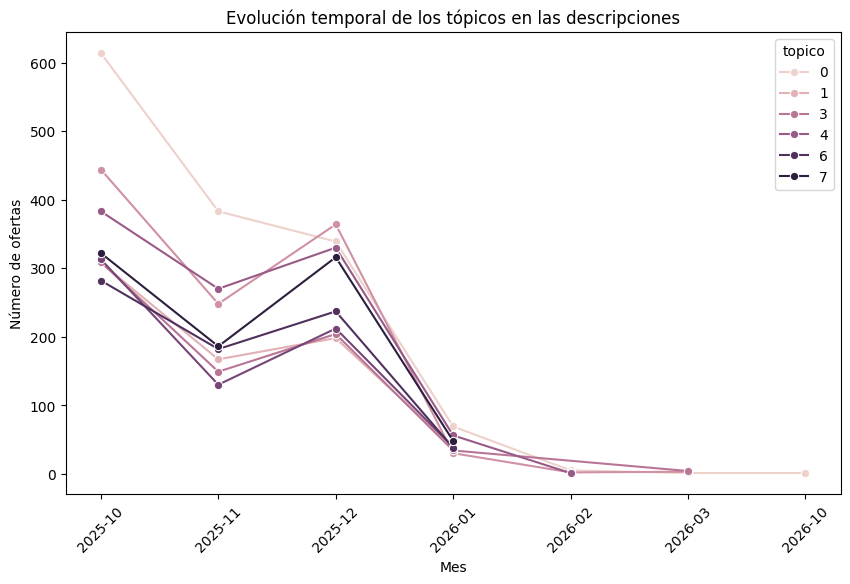

In [67]:
# Por mes
df['mes'] = df['timestamp'].dt.to_period('M')

# Conteo
temporal_topics = df.groupby(['mes', 'topico']).size().reset_index(name='cuenta')

# Convert 'mes' to string for plotting
temporal_topics['mes'] = temporal_topics['mes'].astype(str)

# Gráfico
plt.figure(figsize=(10,6))
sns.lineplot(data=temporal_topics, x='mes', y='cuenta', hue='topico', marker='o')
plt.title('Evolución temporal de los tópicos en las descripciones')
plt.xlabel('Mes')
plt.ylabel('Número de ofertas')
plt.xticks(rotation=45)
plt.show()

# Numerizacion de datos

In [68]:
df = pd.read_csv("EURES_CAT_SENTIMENT.csv", sep=";")

In [72]:
import re
import ast
import pandas as pd

def clean_and_parse(s):
    if isinstance(s, str):
        # 1. Eliminar np.float64( ... )
        s = re.sub(r'np\.float64\((.*?)\)', r'\1', s)
        # 2. Convertir a dict de Python
        return ast.literal_eval(s)
    return s  # si ya es dict

# Aplicar la función a toda la columna
df["probs"] = df["probs"].apply(clean_and_parse)

# Expandir todas las claves en columnas, rellenando con 0
df_expandido = df["probs"].apply(pd.Series).fillna(0)

# Unir con el resto del DataFrame
df_final = pd.concat([df[["id", "timestamp","provincia", "titulo", "sentimiento"]], df_expandido], axis=1)

df_final.columns

df_final.to_csv("EURES_NUMERICO.csv", index=False)

In [73]:
df_topics = pd.DataFrame(
    doc_topics,
    columns=[f"topico_{i}" for i in range(doc_topics.shape[1])],
    index=df.index  # para alinear con df original
)

# Concatenar con tu DataFrame original
df_final = pd.concat([pd.read_csv("EURES_NUMERICO.csv"), df_topics], axis=1)

# Ahora puedes ver cada documento con todas las probabilidades
df_final.head()

,id,timestamp,provincia,titulo,sentimiento,Hostelería y Turismo,Sanitario y Salud,Educación y Formación,Tecnología y Telecomunicaciones,Construcción e Inmobiliaria,...,Administración y Finanzas,"Cultura, Arte y Ocio",topico_0,topico_1,topico_2,topico_3,topico_4,topico_5,topico_6,topico_7
0,https://europa.eu/eures/portal/jv-se/jv-detail...,10/10/2025,Asturias,AGENTE COMERCIAL DE SEGUROS (REF.: 6891),0,0.041404,0.120992,0.041573,0.059019,0.030701,...,0.324229,0.019733,0.026325,0.026326,0.814183,0.026330,0.027860,0.026326,0.026325,0.026325
1,https://europa.eu/eures/portal/jv-se/jv-detail...,10/10/2025,Huesca,PERSONAL CONDUCCIÓN DE CAMIONES RÍGIDOS Y GÓND...,0,0.030990,0.057478,0.036322,0.029180,0.147316,...,0.018703,0.017910,0.009713,0.688852,0.009849,0.009813,0.009709,0.252614,0.009740,0.009709
2,https://europa.eu/eures/portal/jv-se/jv-detail...,10/10/2025,Las Palmas,EDUCADORES SOCIALES,0,0.091403,0.192666,0.193061,0.050125,0.051813,...,0.115608,0.070124,0.057161,0.332506,0.055559,0.331964,0.055559,0.055561,0.056131,0.055560
3,https://europa.eu/eures/portal/jv-se/jv-detail...,10/10/2025,Islas Baleares,PIZZERO (REF. 042025002051),0,0.322015,0.063957,0.053818,0.034641,0.071745,...,0.064199,0.136239,0.595359,0.023262,0.023261,0.134708,0.023259,0.023263,0.153550,0.023339
4,https://europa.eu/eures/portal/jv-se/jv-detail...,10/10/2025,Santa Cruz de Tenerife,INTÉRPRETES DE LA LENGUA DE SIGNOS,0,0.080653,0.092984,0.213507,0.103557,0.021882,...,0.032568,0.312488,0.026320,0.026772,0.026344,0.026321,0.026319,0.026320,0.814982,0.026622


In [74]:

df_final.to_csv("empleos-espanoles-eures-2025-numerico.csv", index=False)